In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle


current_dir = os.getcwd()

In [2]:
# get data dir, go one folder back
data_dir = os.path.abspath(os.path.join(current_dir, os.pardir, 'data'))

In [3]:
# read C:\Users\pablo\OneDrive\Desktop\tree_traits\data\Estimated_trait_table_with_monos.csv
df_trait = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\Estimated_trait_table_with_monos.csv')
# df_trait[df_trait[['accepted_bin', 'trait']].duplicated()]
# READ read taxonomic_information.csv
df_tax = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\taxonomic_information.csv')
# read bgci_v1_3_matched_names.csv
df_bgci_old = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\bgci_v1_3_matched_names.csv',
                          usecols=['accepted_bin', 'TaxonName'], sep=',', encoding='latin1')
# read global_tree_search_trees_1_7.csv
df_bgci_new = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\global_tree_search_trees_1_7.csv',
                          usecols=['TaxonName'], sep=',', encoding='latin1')

Note: Check the original dataset and the methods for imputation

In [4]:
# pivot using accepted_bin as index
df_trait_pred = df_trait.pivot_table(index='accepted_bin', columns='trait', values='pred_value', aggfunc='mean')
df_trait_obs = df_trait.pivot_table(index='accepted_bin', columns='trait', values='obs_value', aggfunc='mean')



In [5]:
# get unique values of TaxonName
new_accepted_species = df_bgci_new['TaxonName'].unique()
# filter df_bgci_old with new_accepted_species
df_bgci_old = df_bgci_old[df_bgci_old['TaxonName'].isin(new_accepted_species)]
# list of new accepted_bin
new_accepted_bin = df_bgci_old['accepted_bin'].unique()

# filter new_accepted_bin (some might not be in df_trait_pred)
df_trait_pred = df_trait_pred[df_trait_pred.index.isin(new_accepted_bin)]

# non monocot list
species_list = df_tax['accepted_bin'].tolist()
non_monocot_list = df_tax[df_tax['mono_fern'] == 0]['accepted_bin'].tolist()
# filter out monocots in both
df_trait_pred = df_trait_pred[df_trait_pred.index.isin(non_monocot_list)]
# df_trait_obs = df_trait_obs.loc[non_monocot_list]


# save the log-transformed for the predicted data
df_trait_pred_log = np.log(df_trait_pred)
df_trait_pred_log.to_csv(os.path.join(data_dir, 'traits_pred_log.csv'))

# index from df_trait_pred
species_index = df_trait_pred.index

# keep same species for df_trait_obs if not there put nan column
# df_trait_obs = df_trait_obs.loc[species_index]
# df_trait_obs_log = np.log(df_trait_obs)
# df_trait_obs_log.to_csv(os.path.join(data_dir, 'traits_obs_log.csv'))

In [6]:
df_trait_obs = df_trait_obs[df_trait_obs.index.isin(new_accepted_bin)]

df_trait_obs = df_trait_obs[df_trait_obs.index.isin(non_monocot_list)]

df_trait_obs_log = np.log(df_trait_obs)

# save
df_trait_obs_log.to_csv(os.path.join(data_dir, 'traits_obs_log.csv'))

In [7]:
# see how many non nans are in obs
df_trait_obs_log.count().sum()

32886

In [8]:
# see which non_monocot_list are angiosperms  
angiosperms = df_tax.loc[df_tax['group'] == 'Angiosperms', ['accepted_bin']]
angiosperms = angiosperms[angiosperms['accepted_bin'].isin(species_index)]
angiosperms = list(angiosperms['accepted_bin'])

# same for Gymnosperms
gymnosperms = df_tax.loc[df_tax['group'] == 'Gymnosperms', ['accepted_bin']]
gymnosperms = gymnosperms[gymnosperms['accepted_bin'].isin(species_index)]
gymnosperms = list(gymnosperms['accepted_bin'])

# save list as df
df_angiosperms = pd.DataFrame(angiosperms, columns=['accepted_bin'])
df_gymnosperms = pd.DataFrame(gymnosperms, columns=['accepted_bin'])

df_angiosperms.to_csv(os.path.join(data_dir, 'angiosperms.csv'))
df_gymnosperms.to_csv(os.path.join(data_dir, 'gymnosperms.csv'))


In [9]:
errors_dic = {}
errors_dic['angiosperm'] = {}
errors_dic['gymnosperm'] = {}
full_distribution_errors = []
full_distribution_gymnosperms = []
full_distribution_angiosperms = []
for trait in df_trait_obs.columns:
    errors_dic[trait] = list(np.log(df_trait_pred[trait]/df_trait_obs[trait]))
    # remove nans
    errors_dic[trait] = [x for x in errors_dic[trait] if str(x) != 'nan']
    # add to full distribution
    full_distribution_errors += errors_dic[trait]

    # angiosperm case
    errors_dic['angiosperm'][trait] = list(np.log(df_trait_pred.loc[angiosperms, trait]/df_trait_obs.loc[:, trait]))
    # remove nans
    errors_dic['angiosperm'][trait] = [x for x in errors_dic['angiosperm'][trait] if str(x) != 'nan']
    # add to full distribution
    full_distribution_angiosperms += errors_dic['angiosperm'][trait]

    # gymnosperm case
    errors_dic['gymnosperm'][trait] = list(np.log(df_trait_pred.loc[gymnosperms, trait]/df_trait_obs.loc[:, trait]))
    # remove nans
    errors_dic['gymnosperm'][trait] = [x for x in errors_dic['gymnosperm'][trait] if str(x) != 'nan']
    # add to full distribution
    full_distribution_gymnosperms += errors_dic['gymnosperm'][trait]


# iterate over traits that are only in df_trait_pred
for trait in df_trait_pred.columns:
    if trait not in df_trait_obs.columns:
        errors_dic[trait] = full_distribution_errors
        # add to angiosperm case and gymnosperm case
        errors_dic['angiosperm'][trait] = full_distribution_angiosperms
        errors_dic['gymnosperm'][trait] = full_distribution_gymnosperms

# save errors_dic as pickle
import pickle
with open('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\error_pred_dist.pkl', 'wb') as f:
    pickle.dump(errors_dic, f)

# iterate over keys and plot histograms
# for key in errors_dic.keys():
#     print(key)
#     plt.hist(errors_dic[key], bins=100)
#     plt.show()

In [10]:
# get columns that are only in df_trait_pred
print(df_trait_obs.columns)

Index(['Bark thickness', 'Leaf K per mass', 'Leaf N per mass',
       'Leaf P per mass', 'Leaf Vcmax per dry mass', 'Leaf area',
       'Leaf density', 'Leaf thickness', 'Seed dry mass', 'Specific leaf area',
       'Stem conduit diameter', 'Stomatal conductance', 'Wood density'],
      dtype='object', name='trait')


In [11]:
linewidth = 6.30045 # latex linewidth in inches 

In [12]:
shortened_trait_names = {
    'Leaf density': 'Leaf Dens.',
    'Wood density': 'Wood Dens.',
    'Root depth': 'Root Depth',
    'Specific leaf area': 'Spec. Leaf Area',
    'Leaf thickness': 'Leaf Thick.',
    'Leaf N per mass': 'Leaf N/Mass',
    'Leaf K per mass': 'Leaf K/Mass',
    'Leaf P per mass': 'Leaf P/Mass',
    'Stem conduit diameter': 'Stem Cond. Diam.',
    'Leaf Vcmax per dry mass': 'Leaf Vcmax/Mass',
    'Stomatal conductance': 'Stomatal Cond.',
    'Leaf area': 'Leaf Area',
    'Crown height': 'Crown Height',
    'Crown diameter': 'Crown Diam.',
    'Tree height': 'Tree Height',
    'Seed dry mass': 'Seed Mass',
    'Bark thickness': 'Bark Thick.',
    'Stem diameter': 'Stem Diam.'
}

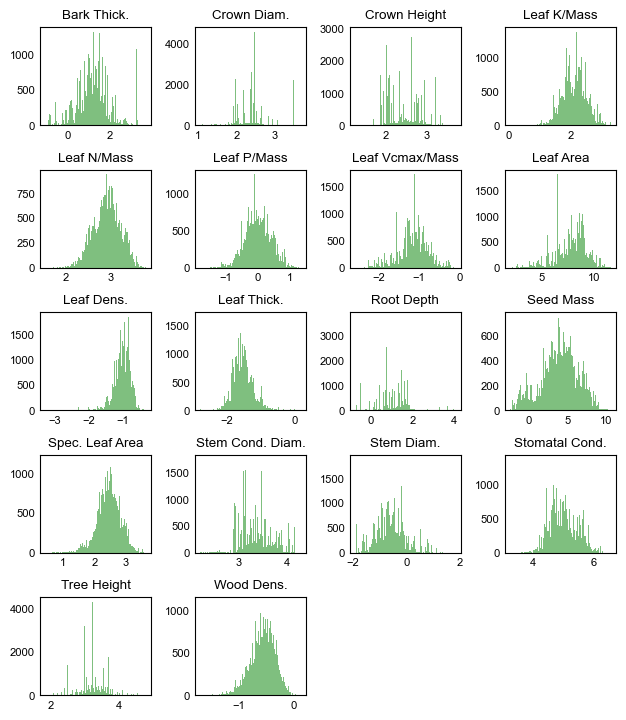

In [26]:
# Set the font size and family
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'font.family': 'Arial'})

# Number of traits per row
traits_per_row = 4

# Number of rows needed
num_rows = int(np.ceil(len(df_trait_pred.columns) / traits_per_row))

# Create a figure and axes
fig, axes = plt.subplots(num_rows, traits_per_row, figsize=(linewidth, linewidth*1.15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each trait
for i, trait in enumerate(df_trait_pred.columns):
    axes[i].hist(np.log(df_trait_pred[trait]), bins=200, color='green', alpha=0.5)
    # axes[i].set_title(trait)
    # use shortened names
    axes[i].set_title(shortened_trait_names[trait])
    axes[i].tick_params(axis='both', which='both', length=0)
    axes[i].grid(False)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

image_path = 'C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\server\\images'
plt.savefig(os.path.join(image_path, 'trait_distribution.pdf'))

plt.show()

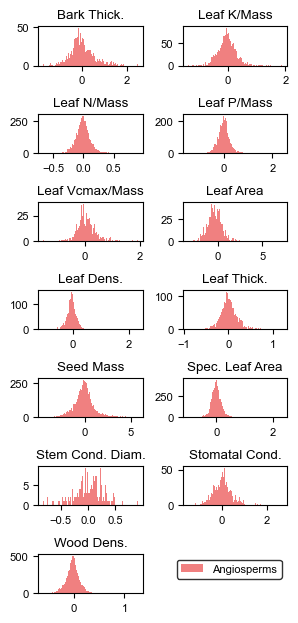

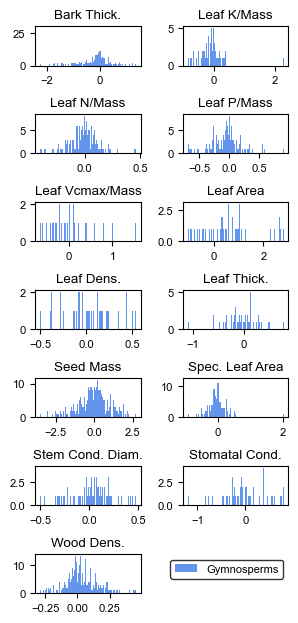

In [36]:
# C:\Users\pablo\OneDrive\Desktop\tree_clustering\server
image_path = 'C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\server\\images'

# Calculate the errors for both angiosperms and gymnosperms
errors_angiosperms = np.log(df_trait_pred.loc[angiosperms, df_trait_obs.columns]) - np.log(df_trait_obs)
errors_gymnosperms = np.log(df_trait_pred.loc[gymnosperms, df_trait_obs.columns]) - np.log(df_trait_obs)

# Rename the columns to shortened names
errors_angiosperms.columns = [shortened_trait_names[col] for col in errors_angiosperms.columns]
errors_gymnosperms.columns = [shortened_trait_names[col] for col in errors_gymnosperms.columns]

# Determine the number of columns and rows for the subplots
num_plots = len(errors_angiosperms.columns)
num_cols = 2  # 3 columns for each plot
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

# Create subplots for angiosperms
fig, axes = plt.subplots(num_rows, num_cols, figsize=(linewidth*0.48, linewidth))
# set fontsize to 8
plt.rcParams.update({'font.size': 8})
# set to arial
plt.rcParams.update({'font.family': 'Arial'})

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot histograms for angiosperms
for i, col in enumerate(errors_angiosperms.columns):
    ax = axes[i]
    errors_angiosperms[col].hist(bins=100, ax=ax, color='lightcoral')
    ax.set_title(col)
    # no grid
    ax.grid(False)

# Remove any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

ax_last = axes[-1]
ax_last.hist([], color='lightcoral', label='Angiosperms')  # Dummy histogram for legend
ax_last.legend(loc='upper right')
ax_last.get_legend().get_frame().set_edgecolor('black')
# remove ticks and axis
ax_last.axis('off')



# don't show any ticks
# plt.setp(axes, xticks=[], yticks=[])

plt.tight_layout()
# plt.suptitle('Angiosperms')
plt.subplots_adjust(top=0.95)  # Adjust the top to make space for the suptitle
plt.savefig(os.path.join(image_path, 'angiosperms_error.pdf'))
plt.show()

# Create subplots for gymnosperms
fig, axes = plt.subplots(num_rows, num_cols, figsize=(linewidth*0.48, linewidth))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot histograms for gymnosperms
for i, col in enumerate(errors_gymnosperms.columns):
    ax = axes[i]
    errors_gymnosperms[col].hist(bins=100, ax=ax, color='cornflowerblue')
    ax.set_title(col)
    # no grid
    ax.grid(False)

# # Remove any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

ax_last = axes[-1]
ax_last.hist([], color='cornflowerblue', label='Gymnosperms')  # Dummy histogram for legend
ax_last.legend(loc='upper right')
ax_last.get_legend().get_frame().set_edgecolor('black')
# remove ticks and axis
ax_last.axis('off')

plt.tight_layout()
# plt.suptitle('Gymnosperms')
plt.subplots_adjust(top=0.95)  # Adjust the top to make space for the suptitle
plt.savefig(os.path.join(image_path, 'gymnosperms_error.pdf'))
plt.show()

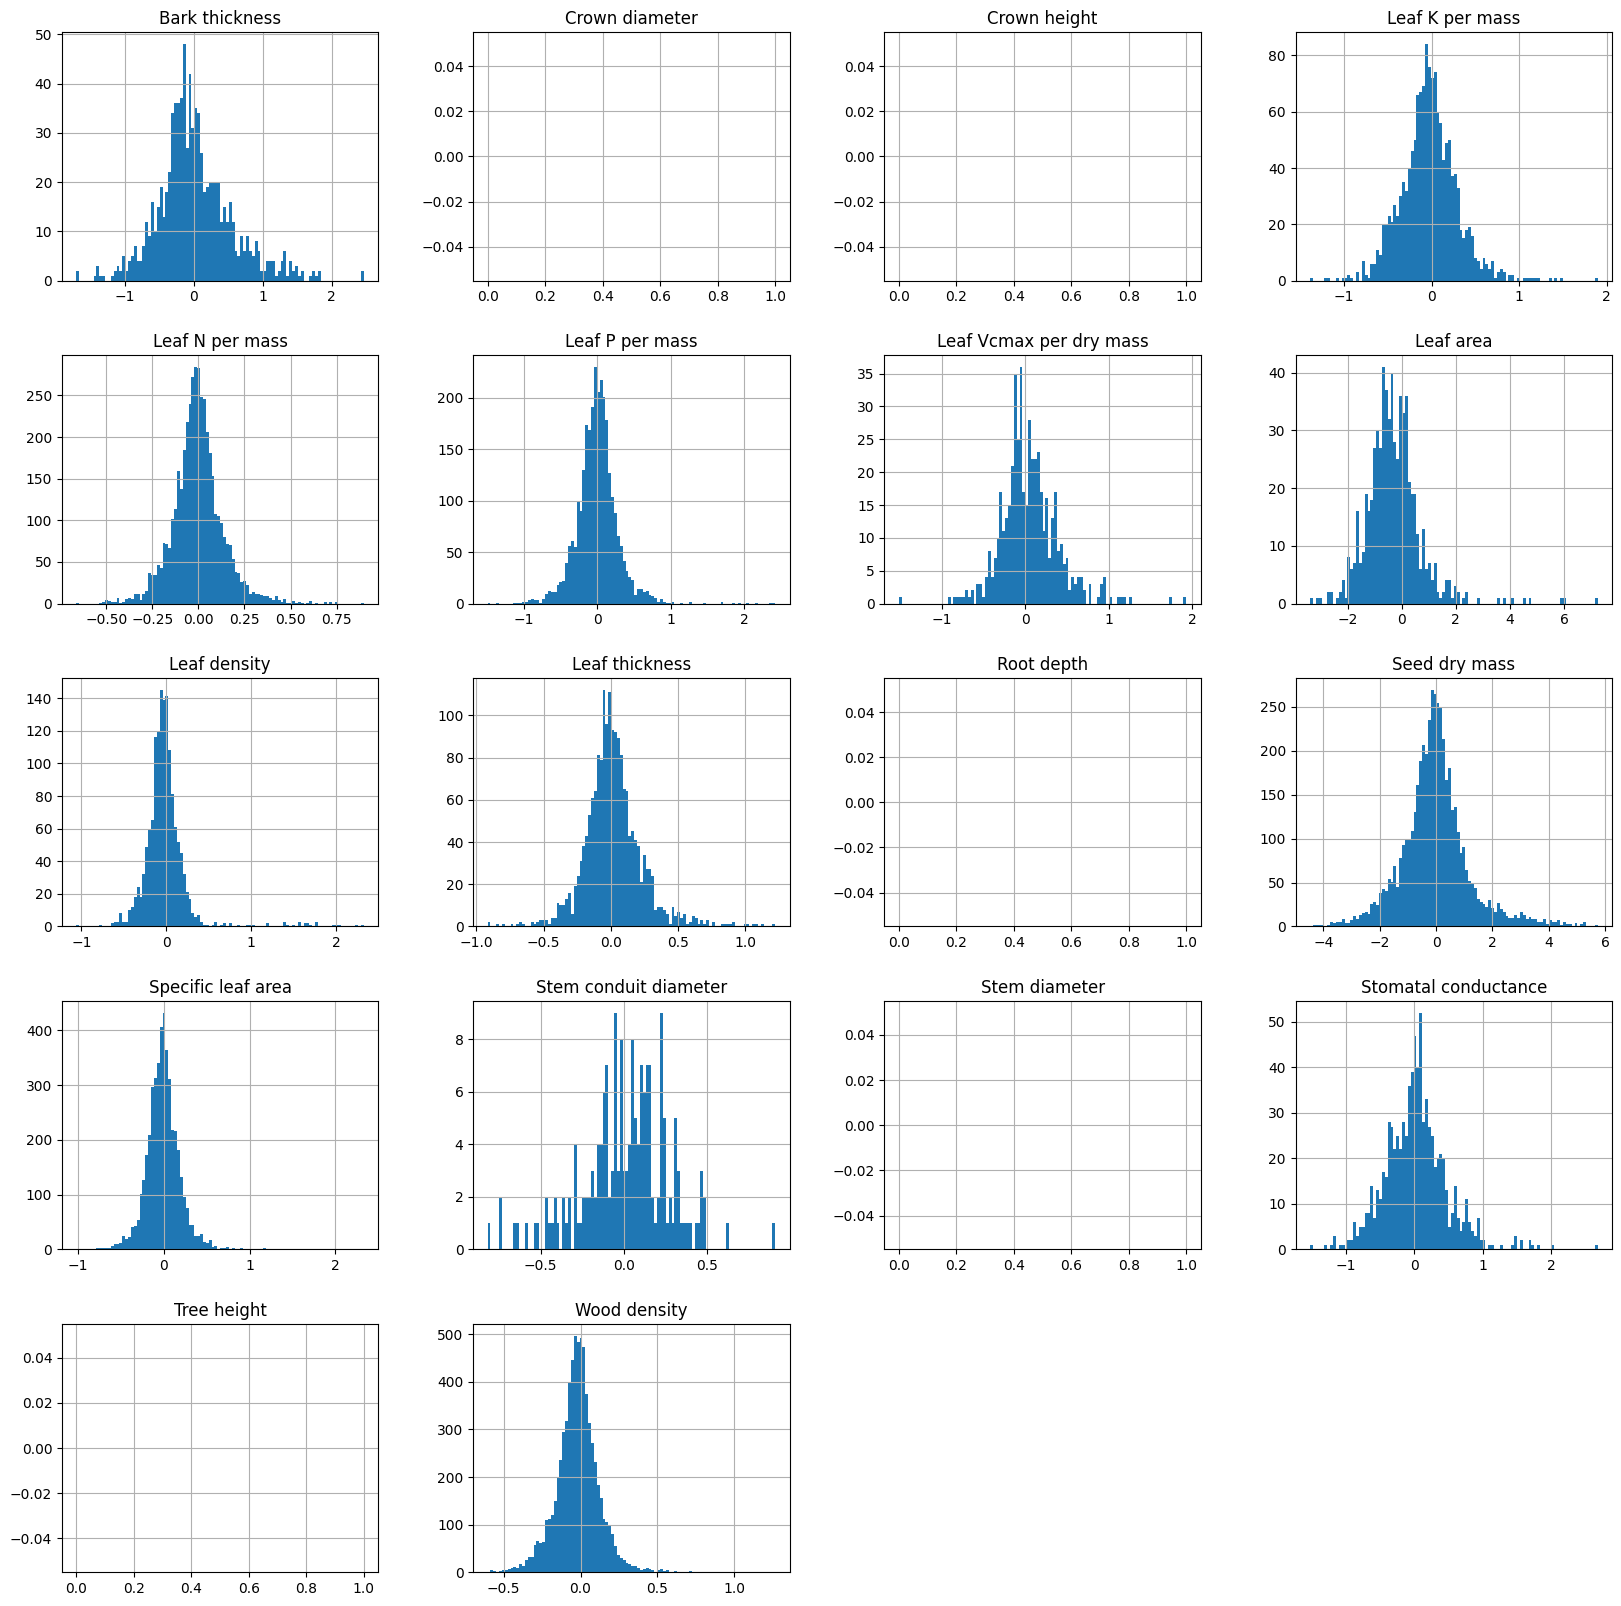

In [12]:
errors = np.log(df_trait_pred.loc[angiosperms]) -np.log(df_trait_obs)

errors.hist(bins = 100, figsize=(20, 20))   
plt.title('Angiosperms')
plt.show()

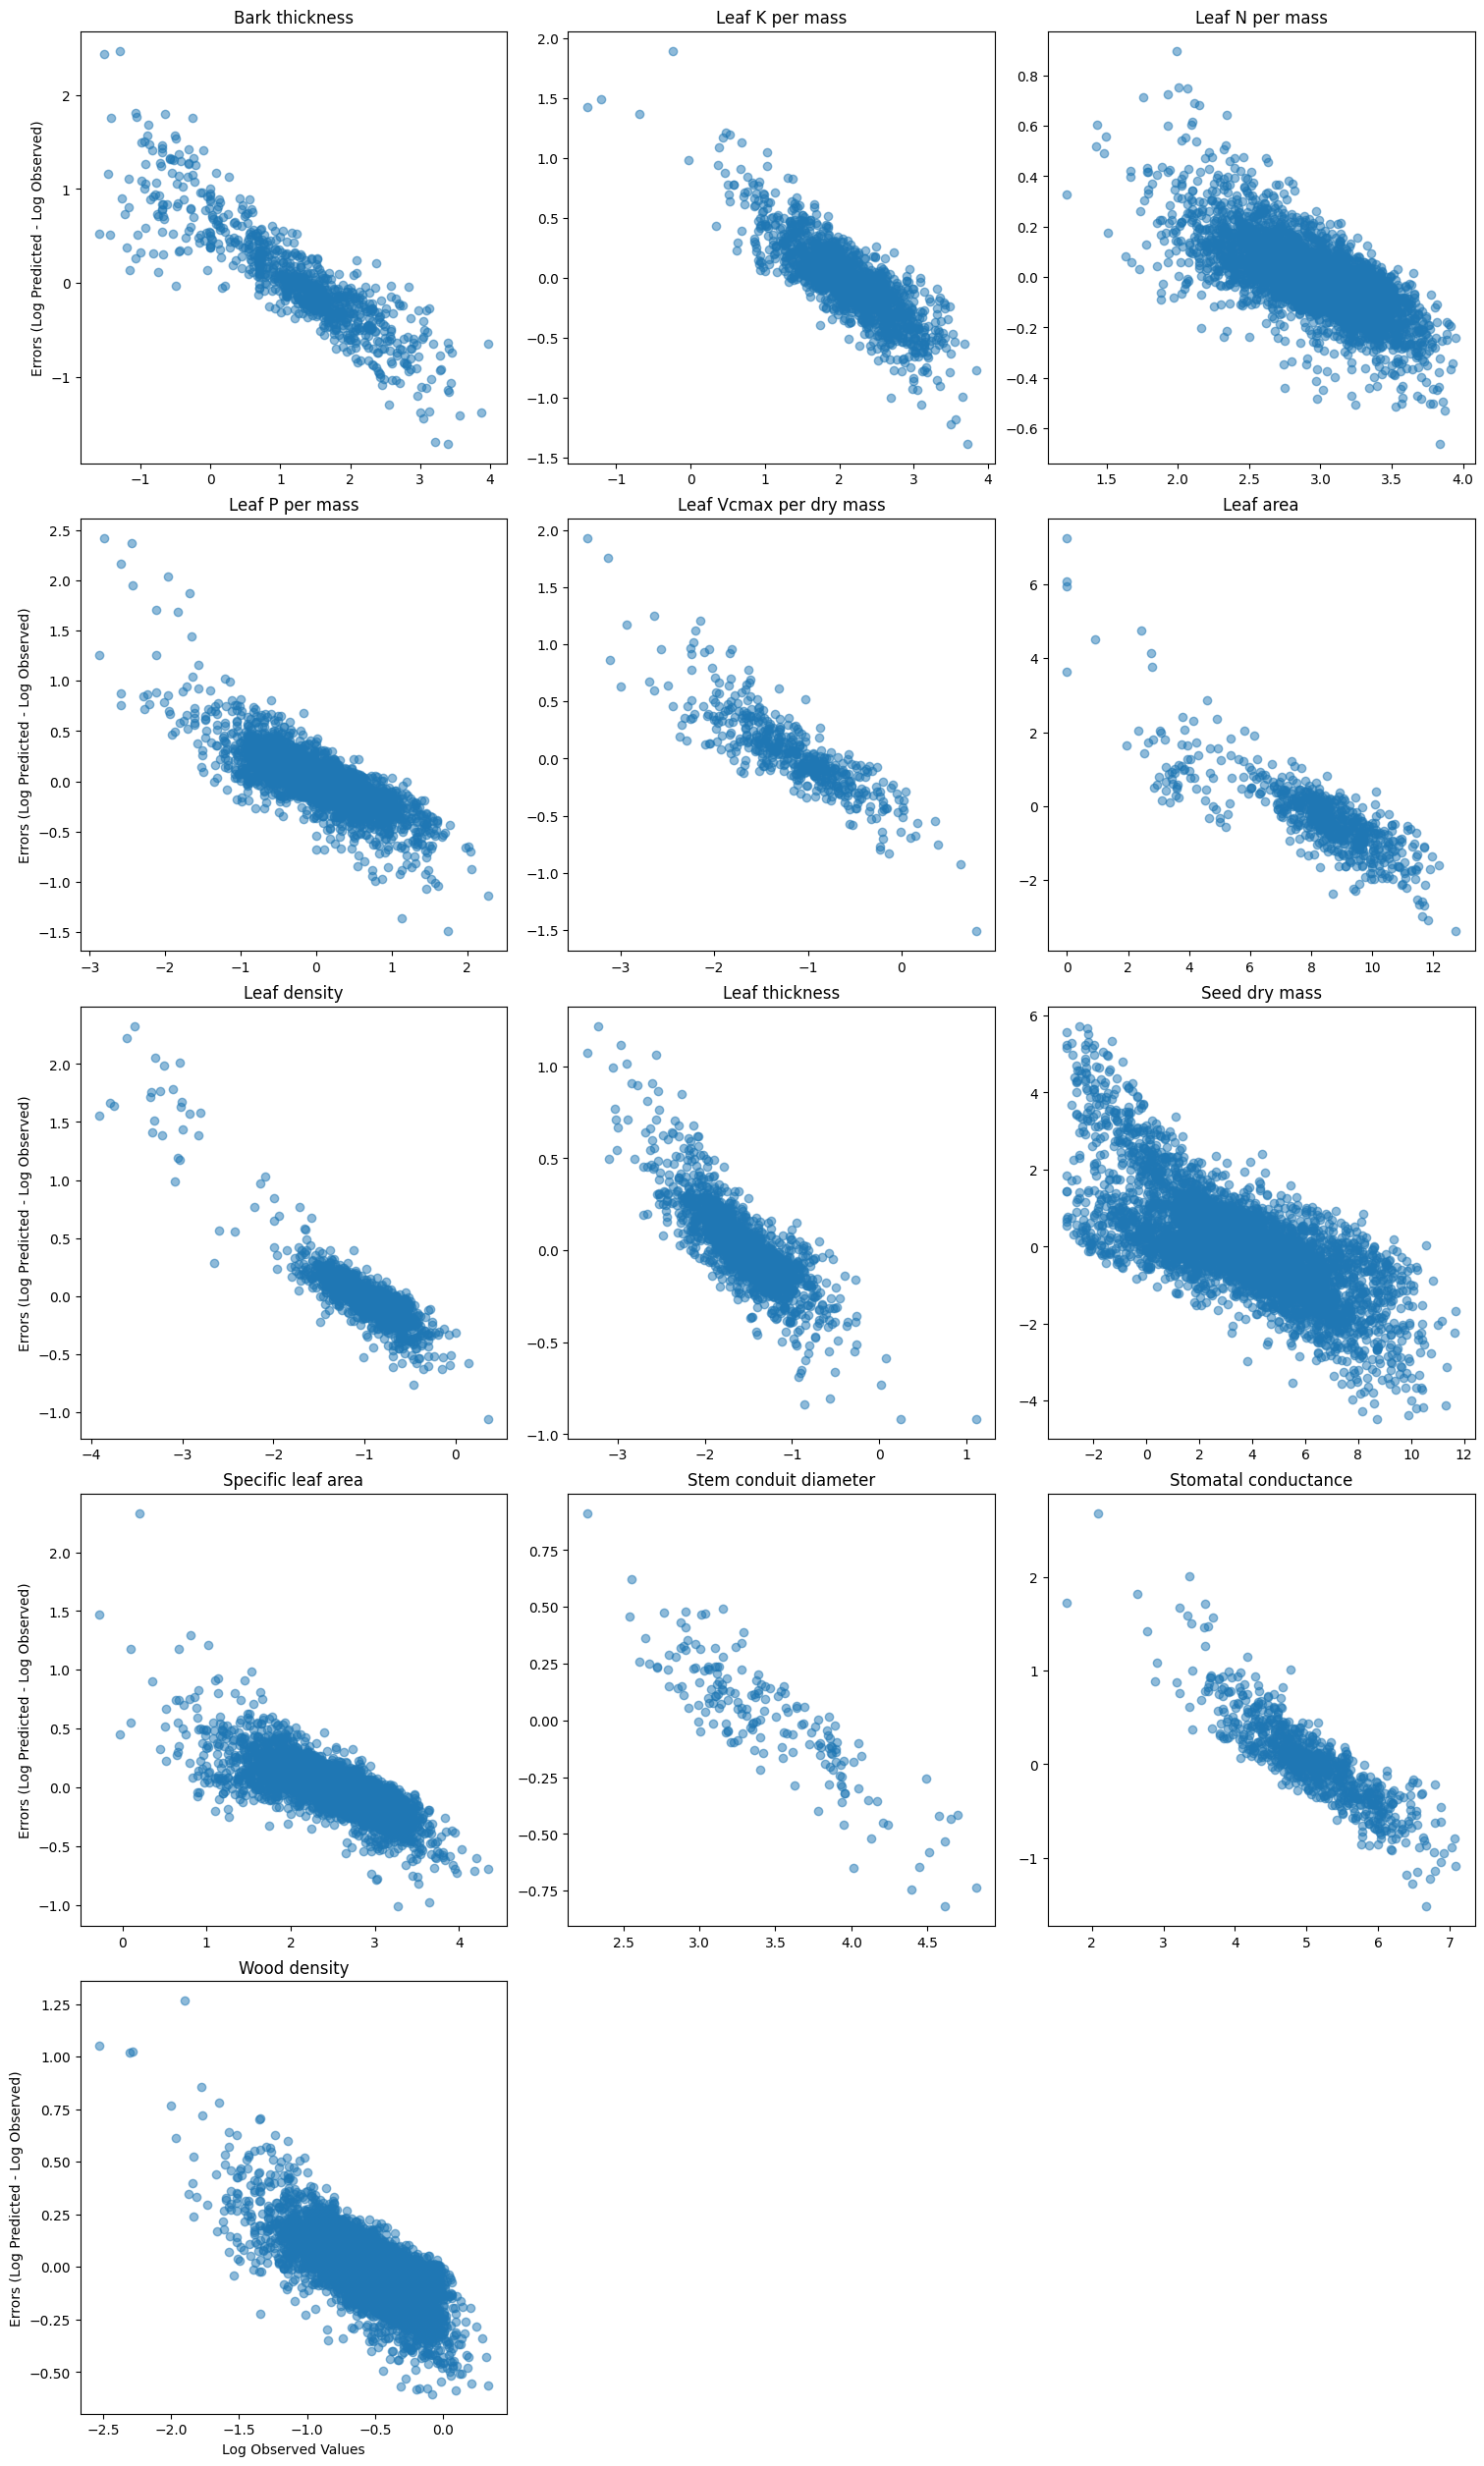

In [34]:
import math

# check which angiosperms are in df_trait_obs
angiosperms_in_obs = [a in df_trait_obs.index for a in angiosperms]
angiosperms_in_obs = [a for a, b in zip(angiosperms, angiosperms_in_obs) if b]

# get errors for angiosperms
errors_angiosperms = np.log(df_trait_pred.loc[angiosperms_in_obs]) -np.log(df_trait_obs.loc[angiosperms_in_obs])


# Calculate the number of rows and columns needed for the subplots
n_traits = df_trait_obs.shape[1]
n_cols = 3  # You can adjust the number of columns as needed
n_rows = math.ceil(n_traits / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), constrained_layout=True, sharex=False, sharey=False)

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, trait in enumerate(df_trait_obs.columns):
    axs[i].scatter(np.log(df_trait_obs.loc[angiosperms_in_obs, trait]), errors_angiosperms[trait], alpha=0.5)
    axs[i].set_title(trait)

    # Set x-axis label for plots in the bottom row
    if i // n_cols == n_rows - 1:
        axs[i].set_xlabel('Log Observed Values')

    # Set y-axis label for plots in the first column
    if i % n_cols == 0:
        axs[i].set_ylabel('Errors (Log Predicted - Log Observed)')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()

In [36]:
print(df_trait_pred.shape)
print(df_trait_obs.shape)
error = np.log(df_trait_pred) - np.log(df_trait_obs)
print(error.shape)

(47828, 18)
(11978, 13)
(47828, 18)


In [66]:
categories = []

for species in df_trait_pred.index:
    if species in angiosperms:
        # categories.append(0)
        categories.append('Angiosperm')
    elif species in gymnosperms:
        # categories.append(1)
        categories.append('Gymnosperm')
    else:
        categories.append('Other')


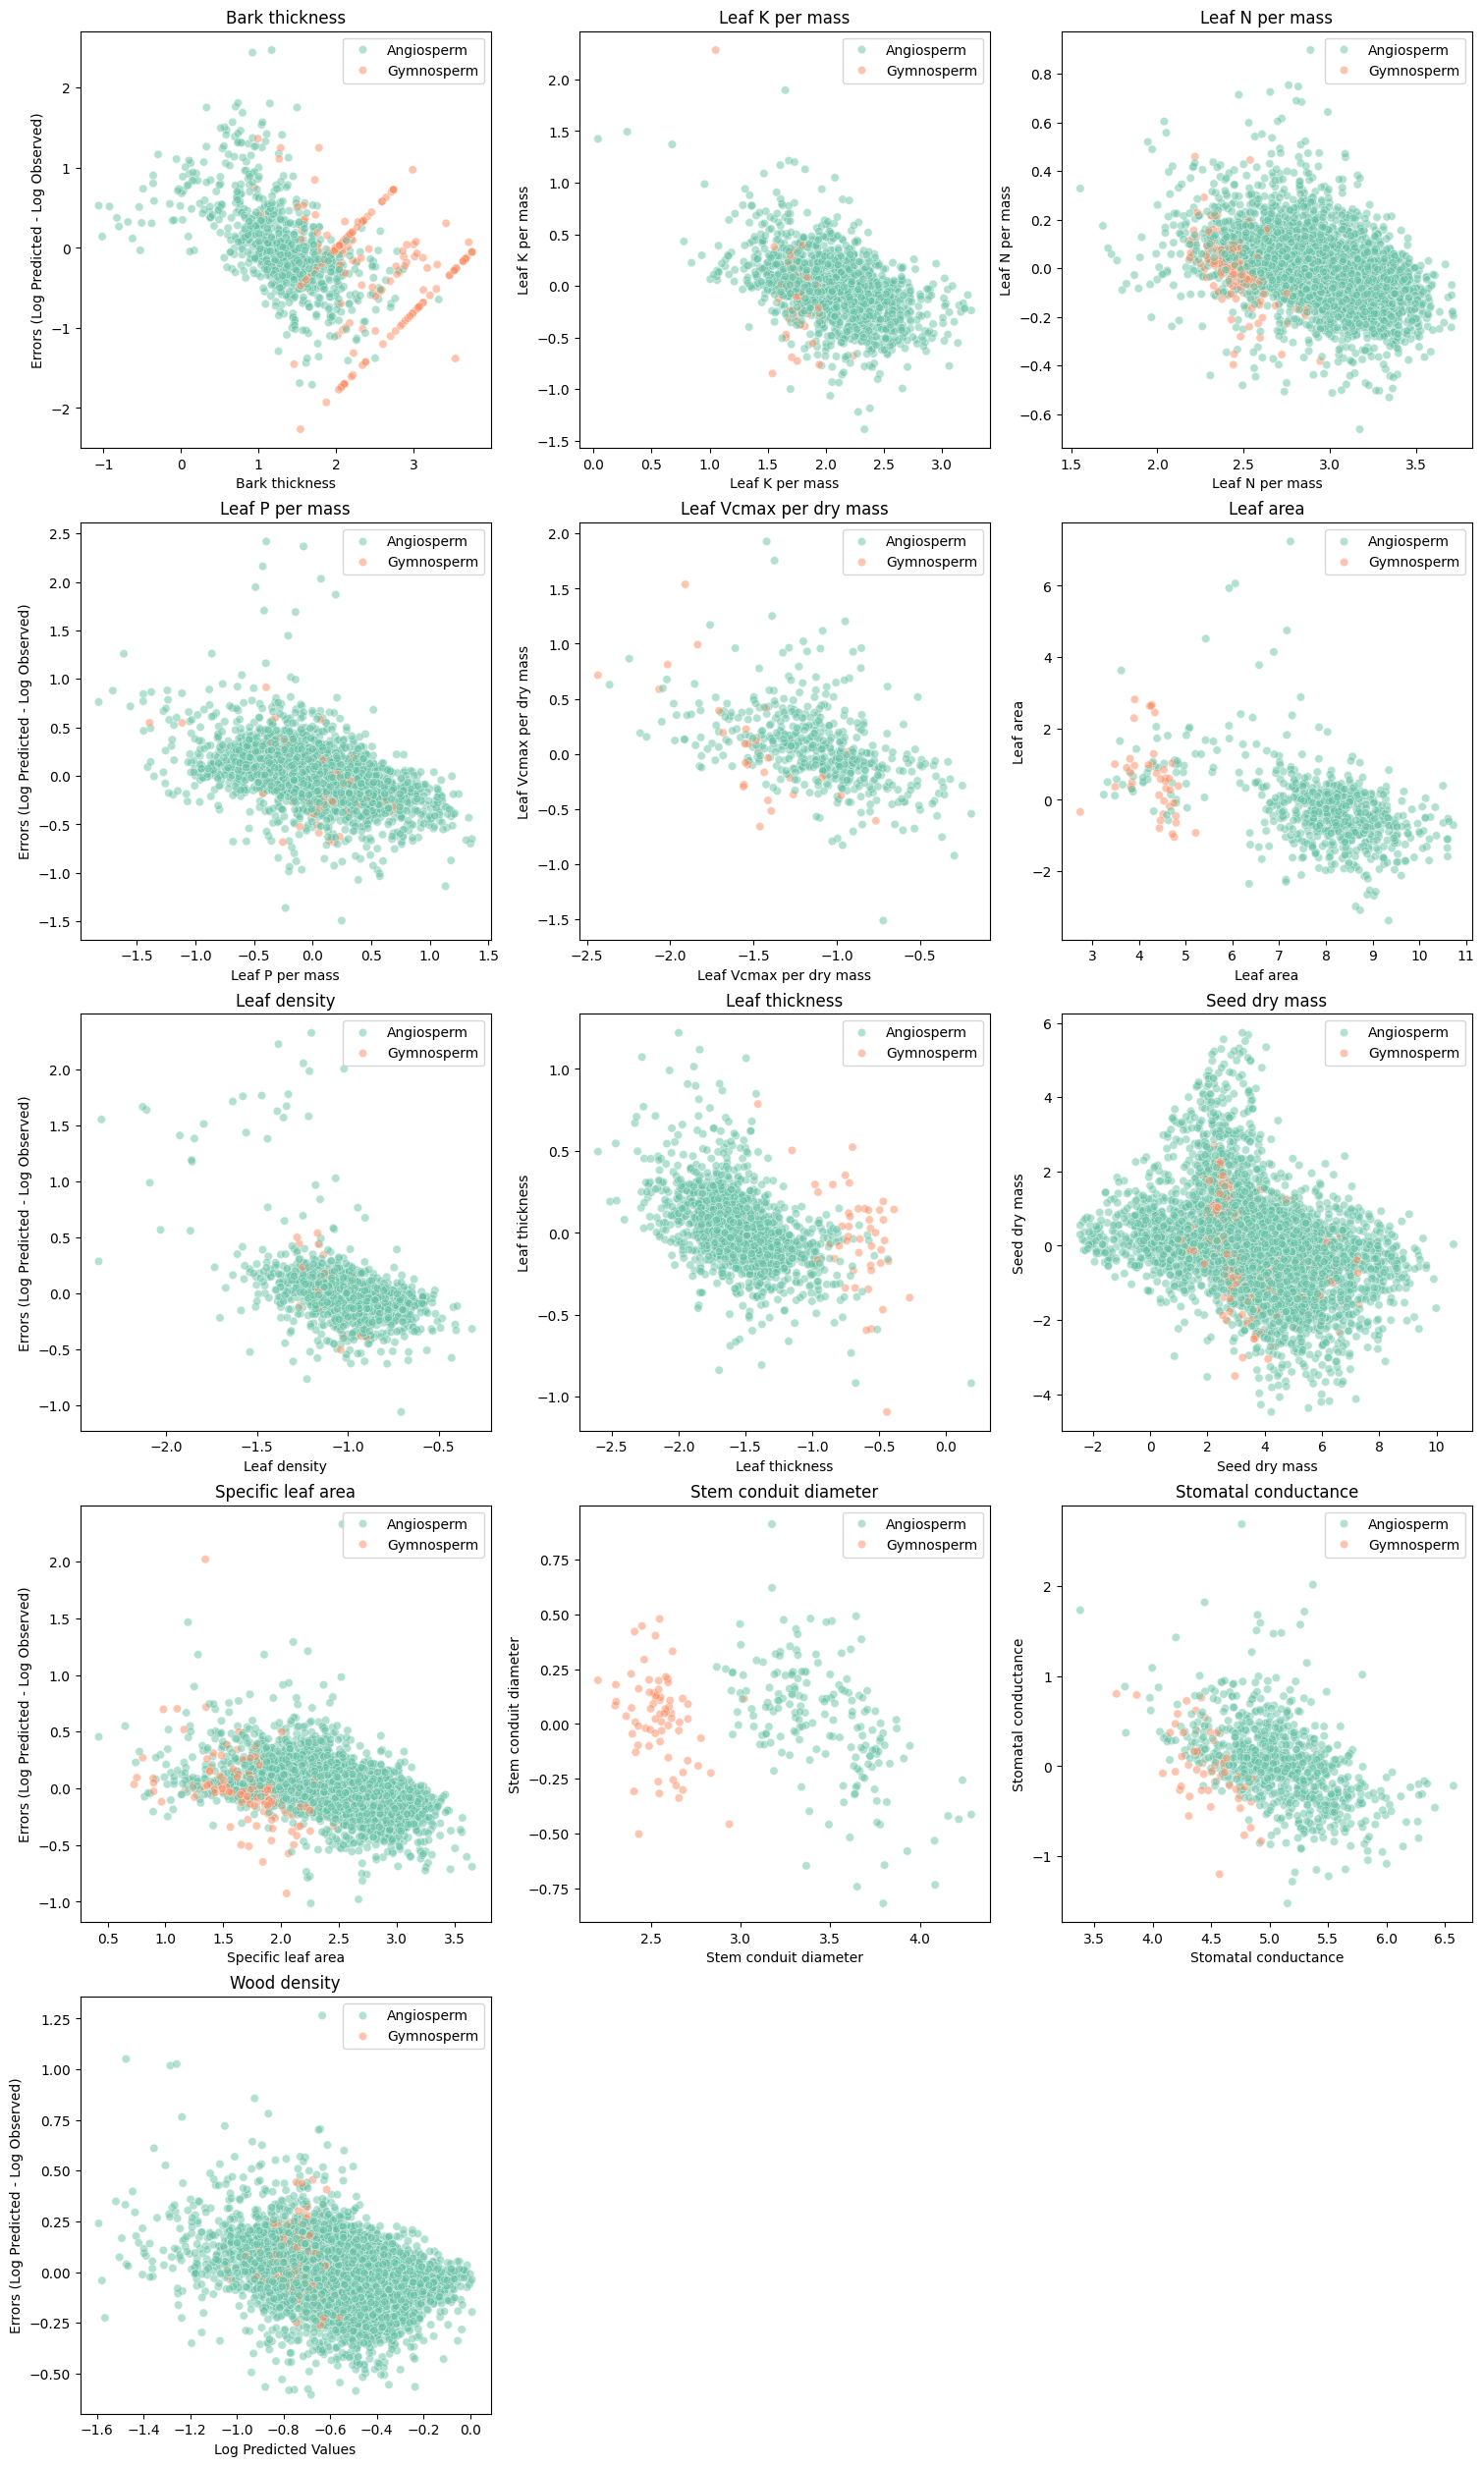

In [70]:
import math
import seaborn as sns

# get errors for angiosperms
errors = np.log(df_trait_pred) - np.log(df_trait_obs)


# Calculate the number of rows and columns needed for the subplots
n_traits = df_trait_obs.shape[1]
n_cols = 3  # You can adjust the number of columns as needed
n_rows = math.ceil(n_traits / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows),
                         constrained_layout=True, sharex=False, sharey=False)

# Flatten the axes array for easy iteration
axs = axs.flatten()



for i, trait in enumerate(df_trait_obs.columns):
    sns.scatterplot(x= np.log(df_trait_pred[trait]),y = errors.loc[df_trait_pred.index, trait], alpha=0.5,
                   hue=categories, palette='Set2', ax = axs[i])
    axs[i].set_title(trait)

    # Set x-axis label for plots in the bottom row
    if i // n_cols == n_rows - 1:
        axs[i].set_xlabel('Log Predicted Values')

    # Set y-axis label for plots in the first column
    if i % n_cols == 0:
        axs[i].set_ylabel('Errors (Log Predicted - Log Observed)')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()

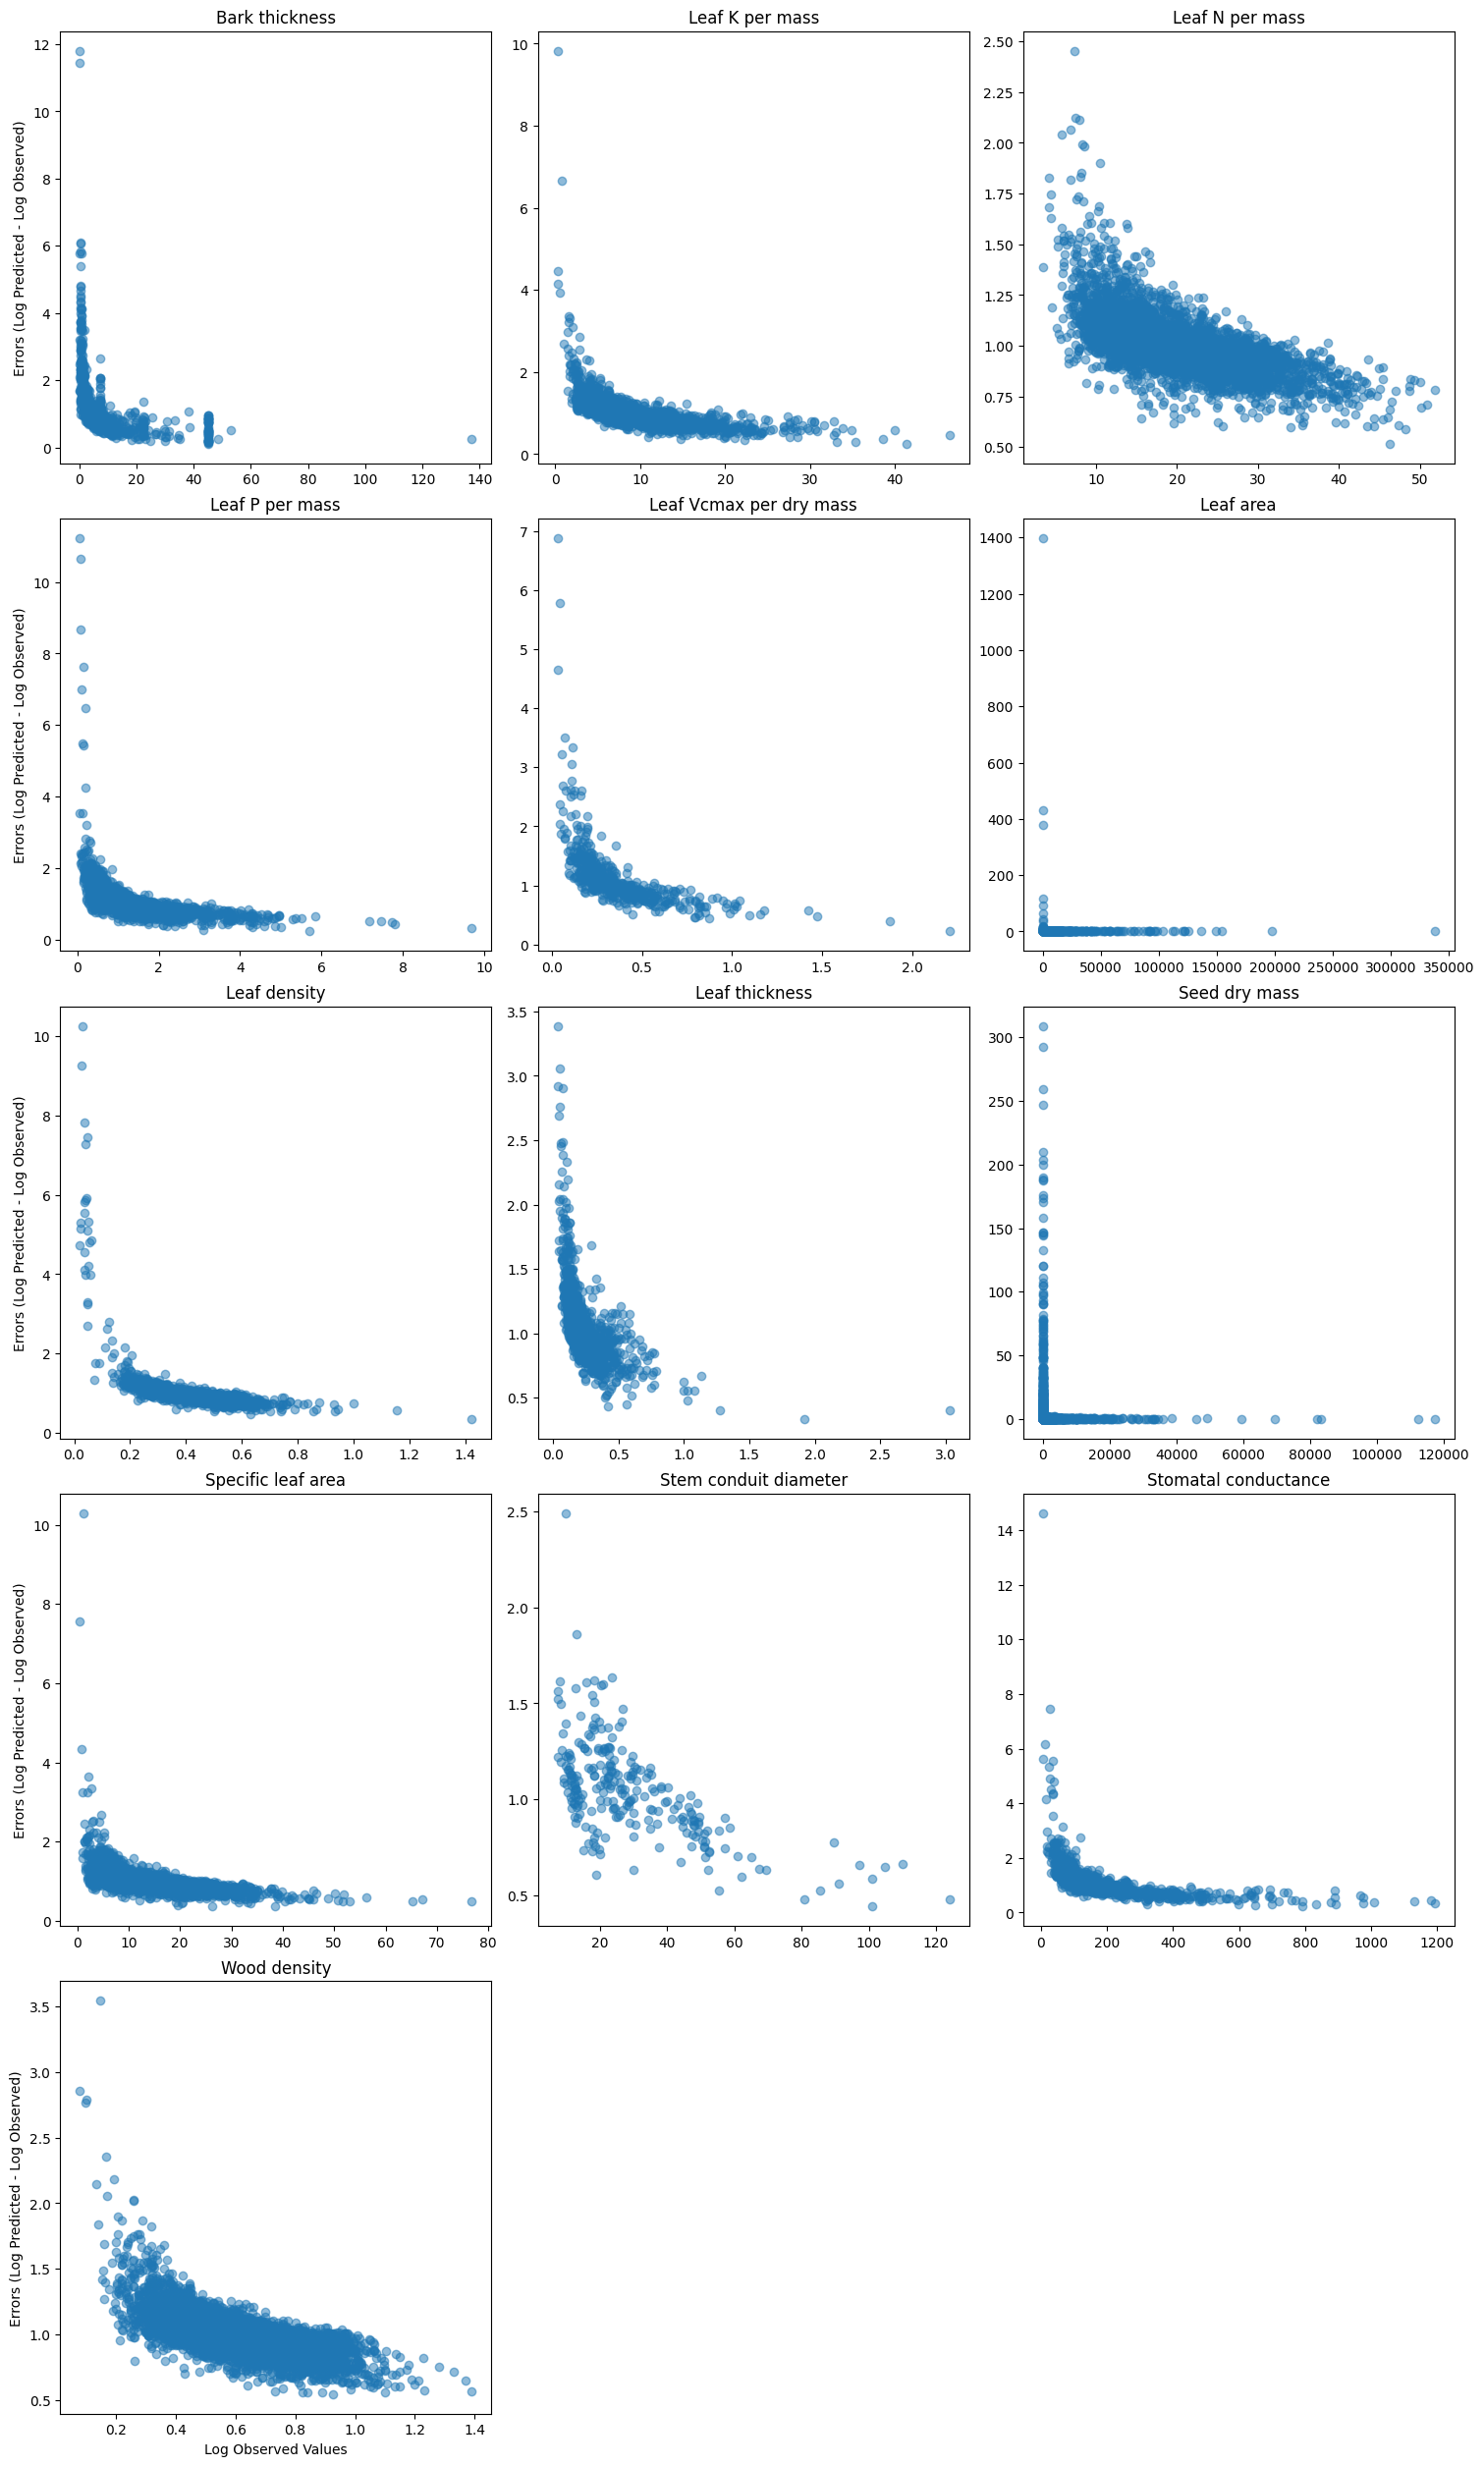

In [40]:
import math

# get errors for angiosperms
errors = df_trait_pred/df_trait_obs


# Calculate the number of rows and columns needed for the subplots
n_traits = df_trait_obs.shape[1]
n_cols = 3  # You can adjust the number of columns as needed
n_rows = math.ceil(n_traits / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), constrained_layout=True, sharex=False, sharey=False)

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, trait in enumerate(df_trait_obs.columns):
    axs[i].scatter(df_trait_obs[trait], errors.loc[df_trait_obs.index, trait], alpha=0.5)
    axs[i].set_title(trait)

    # Set x-axis label for plots in the bottom row
    if i // n_cols == n_rows - 1:
        axs[i].set_xlabel('Log Observed Values')

    # Set y-axis label for plots in the first column
    if i % n_cols == 0:
        axs[i].set_ylabel('Errors (Log Predicted - Log Observed)')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()

array([[<Axes: title={'center': 'Bark thickness'}>,
        <Axes: title={'center': 'Crown diameter'}>,
        <Axes: title={'center': 'Crown height'}>,
        <Axes: title={'center': 'Leaf K per mass'}>],
       [<Axes: title={'center': 'Leaf N per mass'}>,
        <Axes: title={'center': 'Leaf P per mass'}>,
        <Axes: title={'center': 'Leaf Vcmax per dry mass'}>,
        <Axes: title={'center': 'Leaf area'}>],
       [<Axes: title={'center': 'Leaf density'}>,
        <Axes: title={'center': 'Leaf thickness'}>,
        <Axes: title={'center': 'Root depth'}>,
        <Axes: title={'center': 'Seed dry mass'}>],
       [<Axes: title={'center': 'Specific leaf area'}>,
        <Axes: title={'center': 'Stem conduit diameter'}>,
        <Axes: title={'center': 'Stem diameter'}>,
        <Axes: title={'center': 'Stomatal conductance'}>],
       [<Axes: title={'center': 'Tree height'}>,
        <Axes: title={'center': 'Wood density'}>, <Axes: >, <Axes: >]],
      dtype=object)

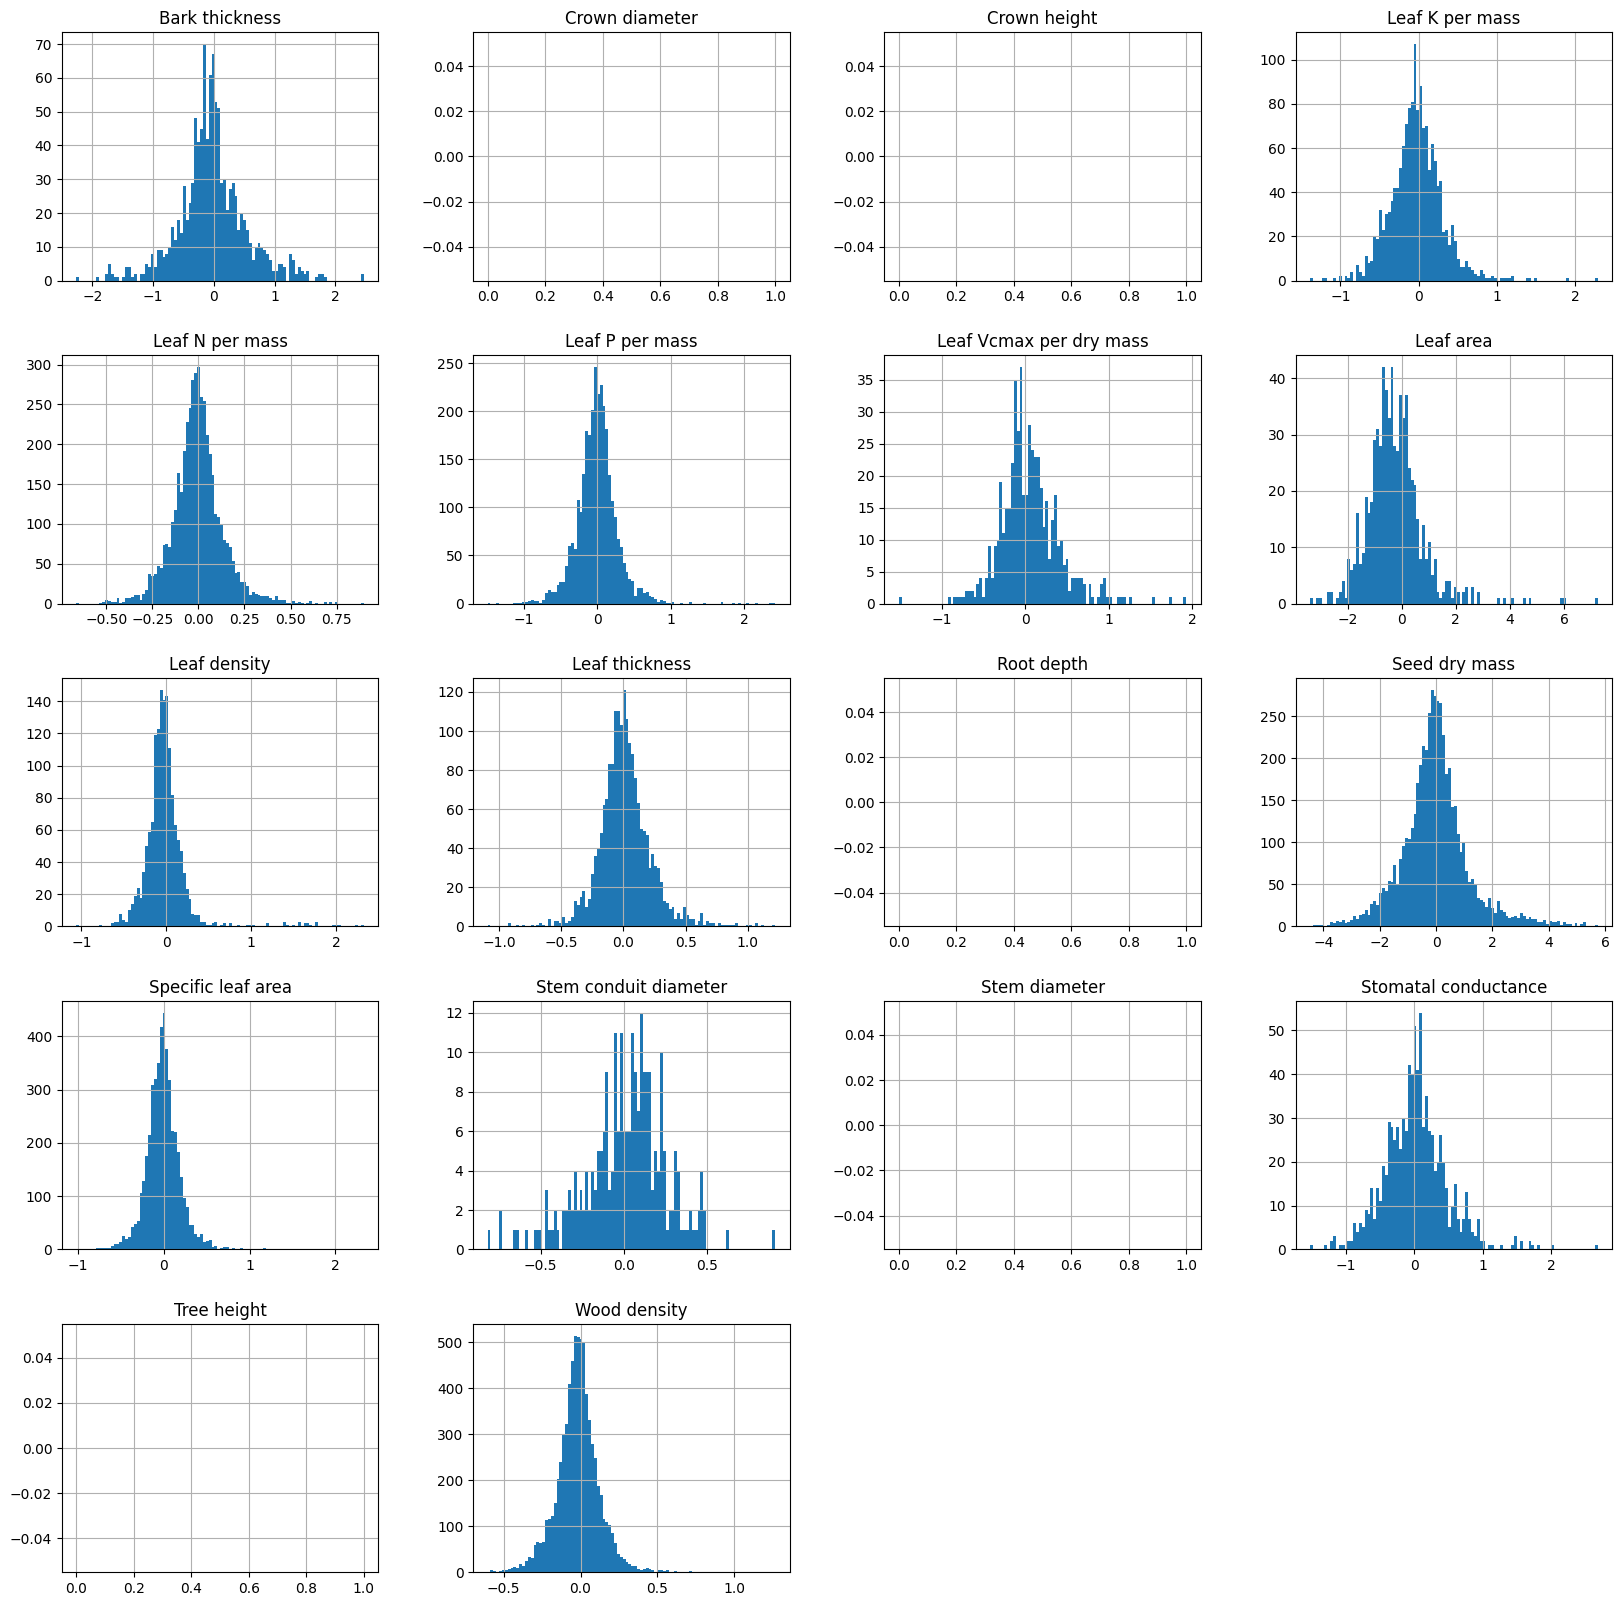

In [8]:
errors = np.log(df_trait_pred) -np.log(df_trait_obs)

errors.hist(bins = 100, figsize=(20, 20))   

array([[<Axes: title={'center': 'Bark thickness'}>,
        <Axes: title={'center': 'Crown diameter'}>,
        <Axes: title={'center': 'Crown height'}>,
        <Axes: title={'center': 'Leaf K per mass'}>],
       [<Axes: title={'center': 'Leaf N per mass'}>,
        <Axes: title={'center': 'Leaf P per mass'}>,
        <Axes: title={'center': 'Leaf Vcmax per dry mass'}>,
        <Axes: title={'center': 'Leaf area'}>],
       [<Axes: title={'center': 'Leaf density'}>,
        <Axes: title={'center': 'Leaf thickness'}>,
        <Axes: title={'center': 'Root depth'}>,
        <Axes: title={'center': 'Seed dry mass'}>],
       [<Axes: title={'center': 'Specific leaf area'}>,
        <Axes: title={'center': 'Stem conduit diameter'}>,
        <Axes: title={'center': 'Stem diameter'}>,
        <Axes: title={'center': 'Stomatal conductance'}>],
       [<Axes: title={'center': 'Tree height'}>,
        <Axes: title={'center': 'Wood density'}>, <Axes: >, <Axes: >]],
      dtype=object)

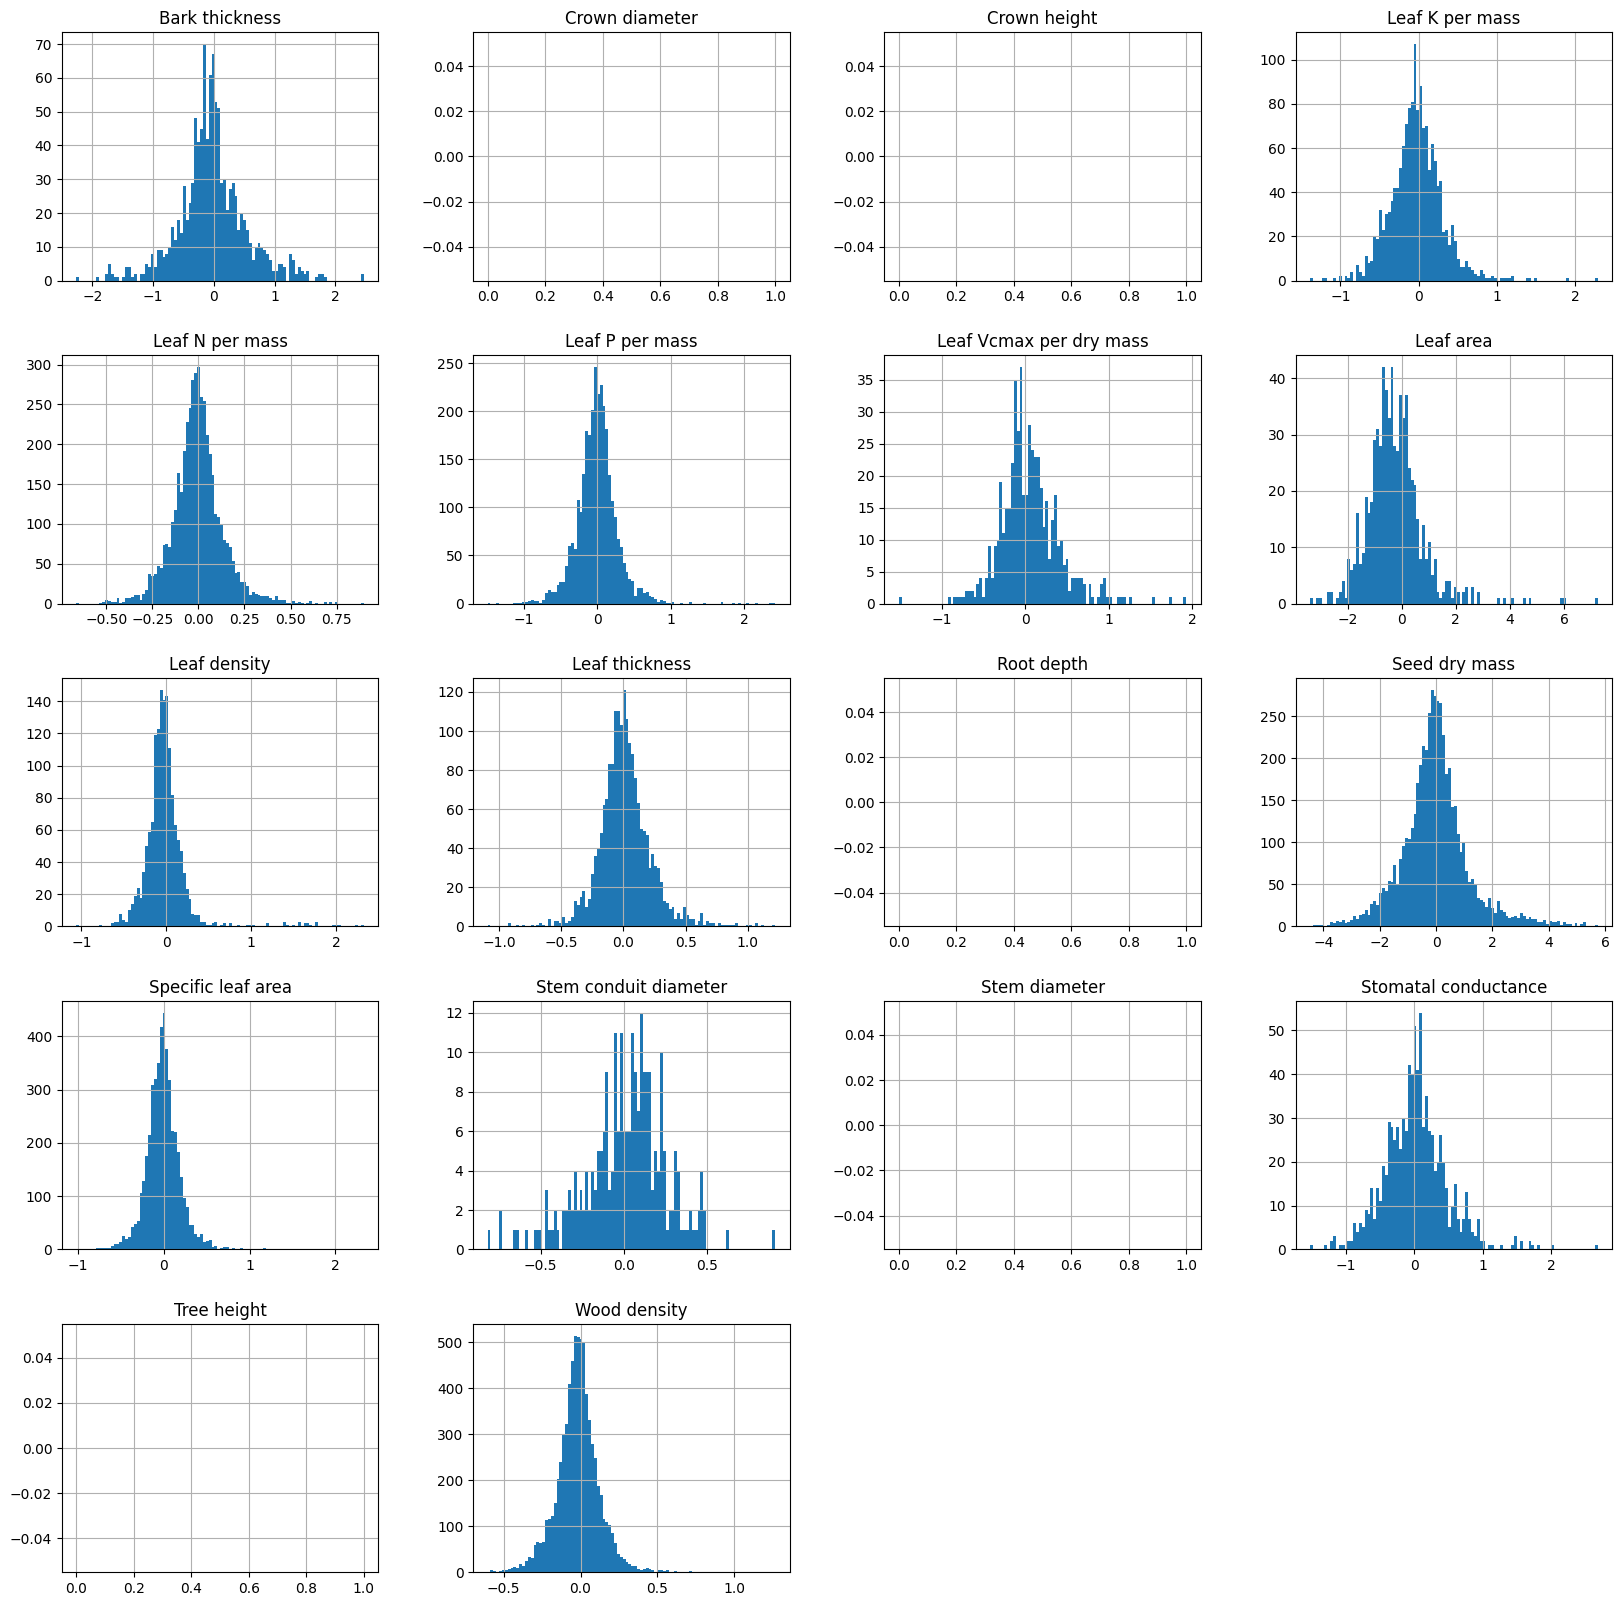

In [7]:
errors = np.log(df_trait_pred/df_trait_obs)

errors.hist(bins = 100, figsize=(20, 20))   

<Axes: >

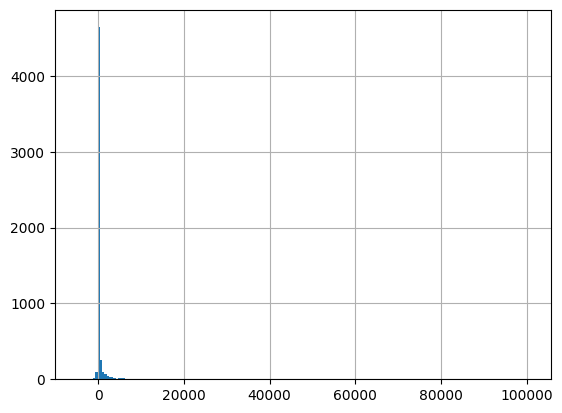

In [25]:
(df_trait_obs - df_trait_pred)['Seed dry mass'].hist(bins = 200)

In [34]:


# for Nans take the mean error
errors = errors.fillna(errors.mean())
# name values pred_error
errors = errors.rename('pred_error')

# store errors in data as pred_erros

errors.to_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\pred_errors.csv')

trait
Bark thickness             0.402793
Crown diameter                  NaN
Crown height                    NaN
Leaf K per mass            0.243714
Leaf N per mass            0.098448
Leaf P per mass            0.198603
Leaf Vcmax per dry mass    0.263919
Leaf area                  0.780120
Leaf density               0.160354
Leaf thickness             0.152029
Root depth                      NaN
Seed dry mass              0.858122
Specific leaf area         0.143699
Stem conduit diameter      0.189679
Stem diameter                   NaN
Stomatal conductance       0.335944
Tree height                     NaN
Wood density               0.102942
dtype: float64

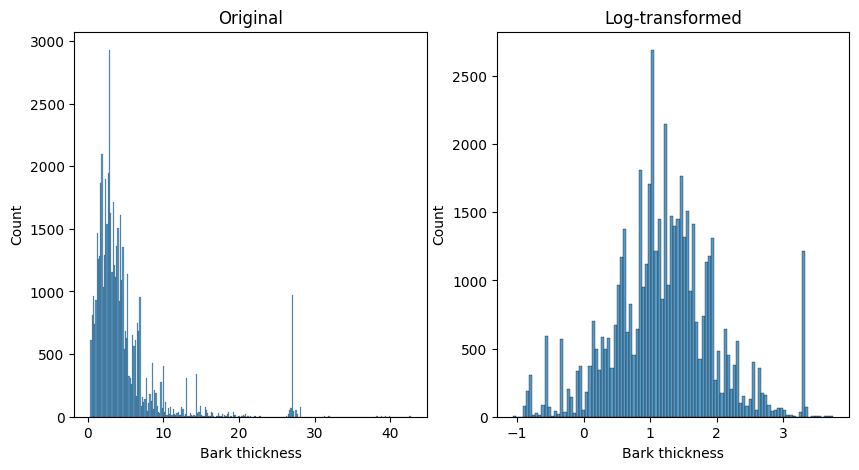

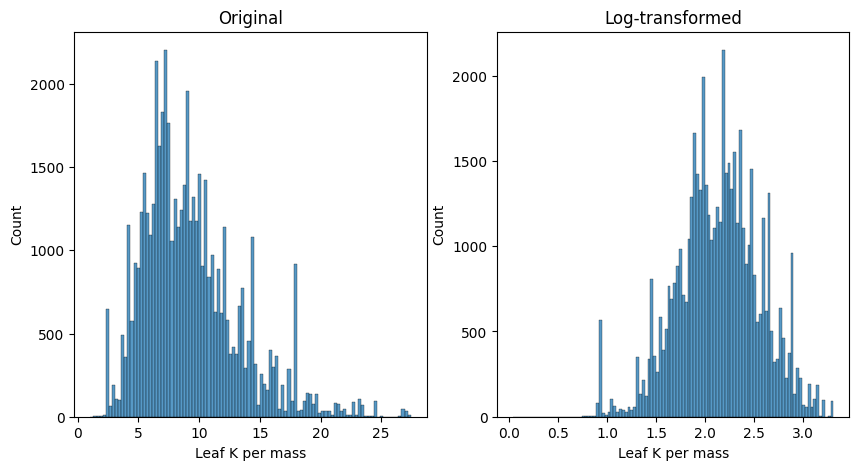

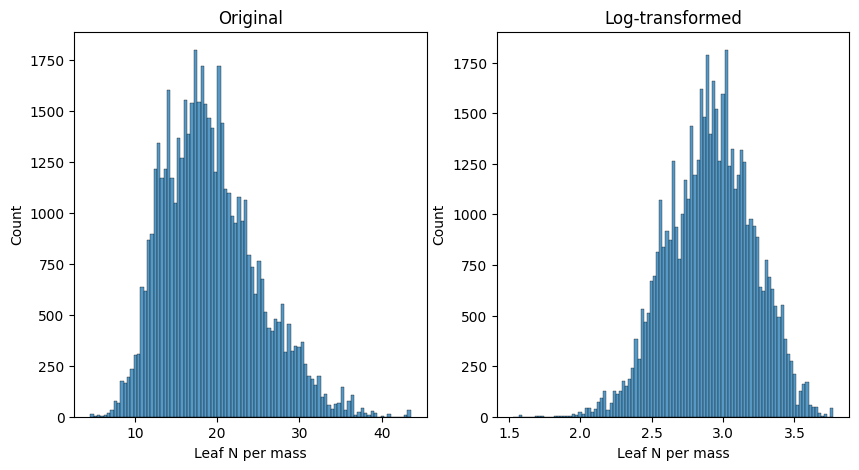

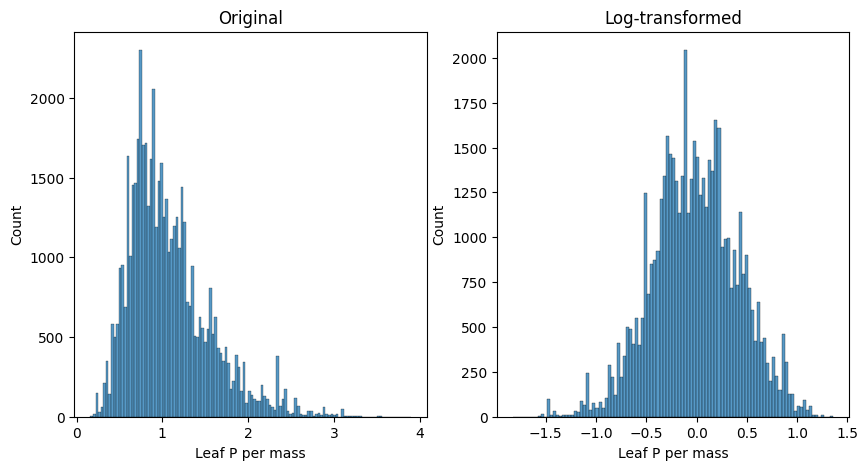

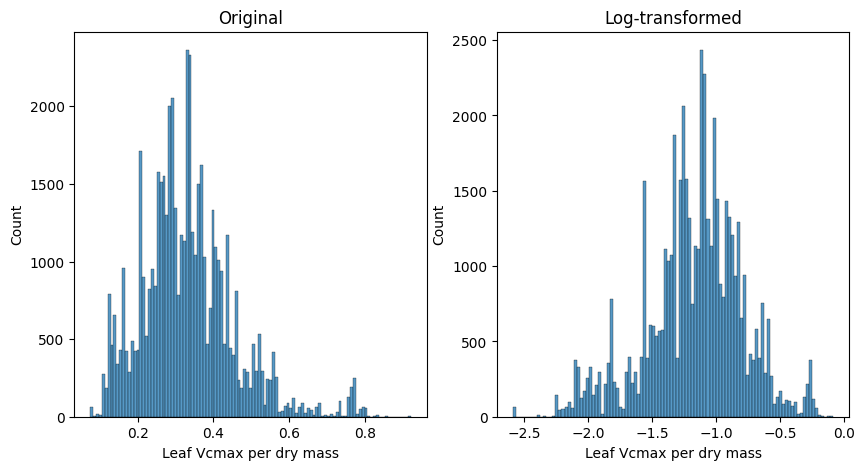

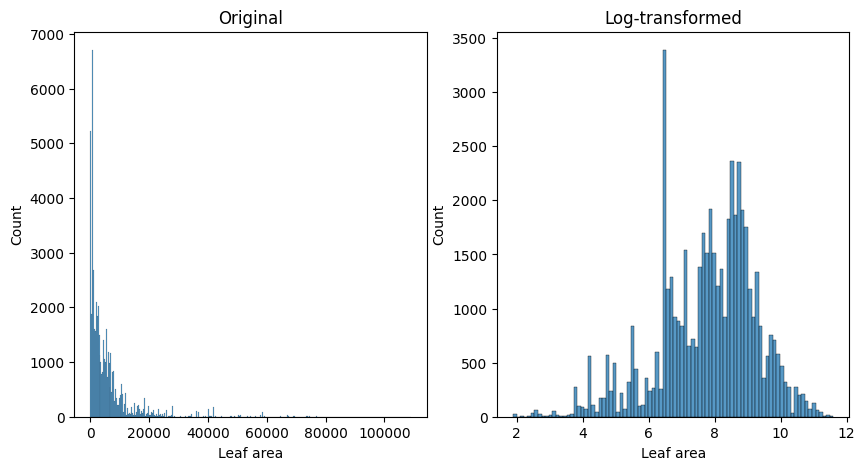

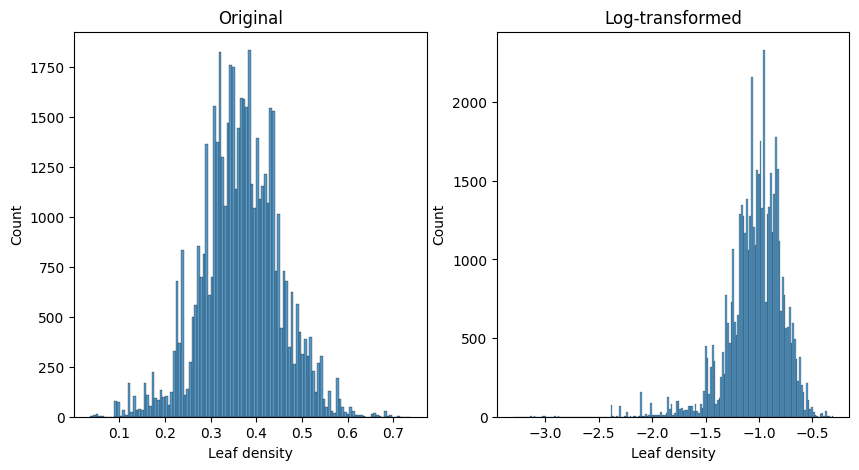

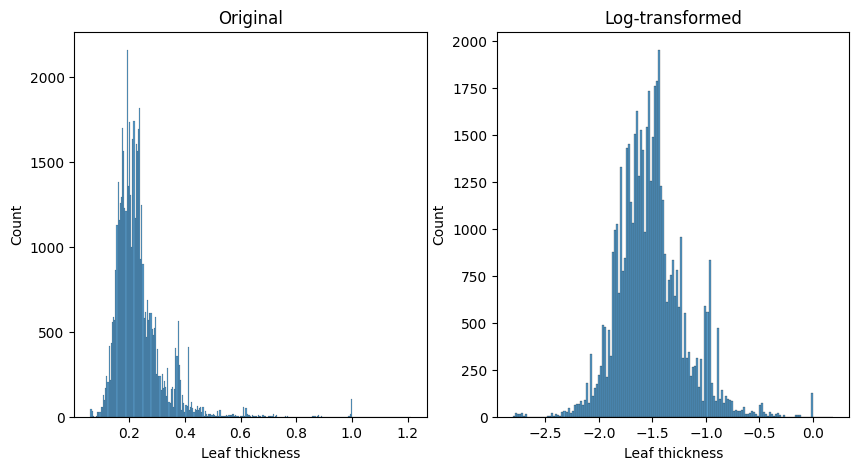

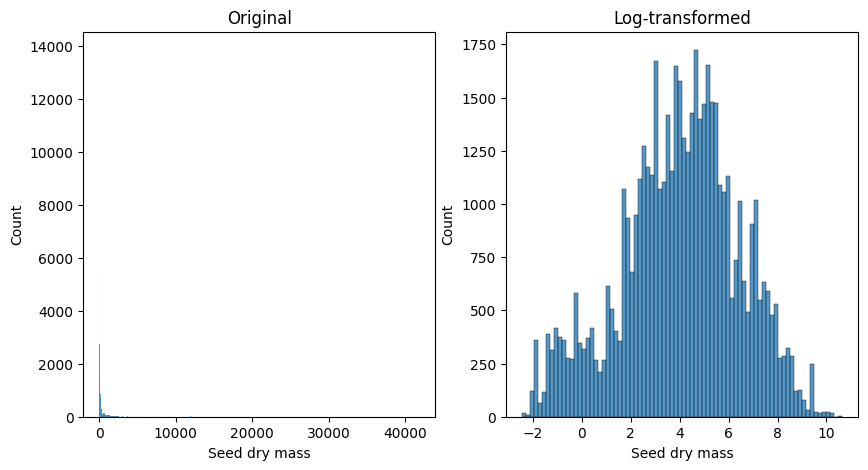

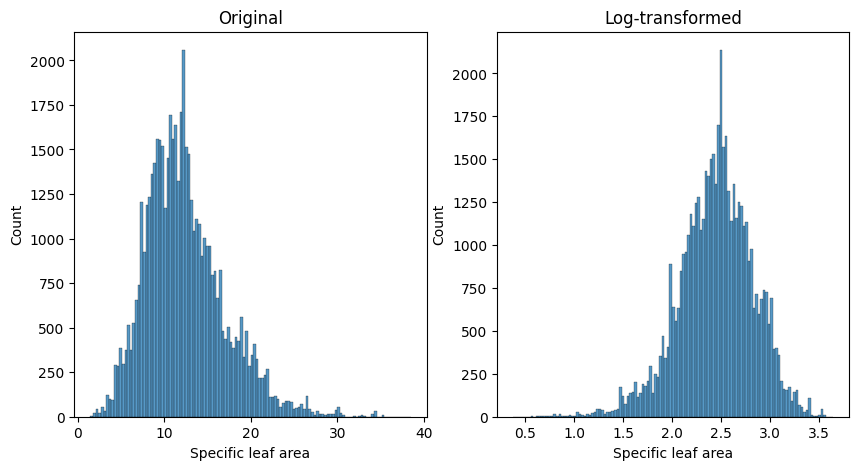

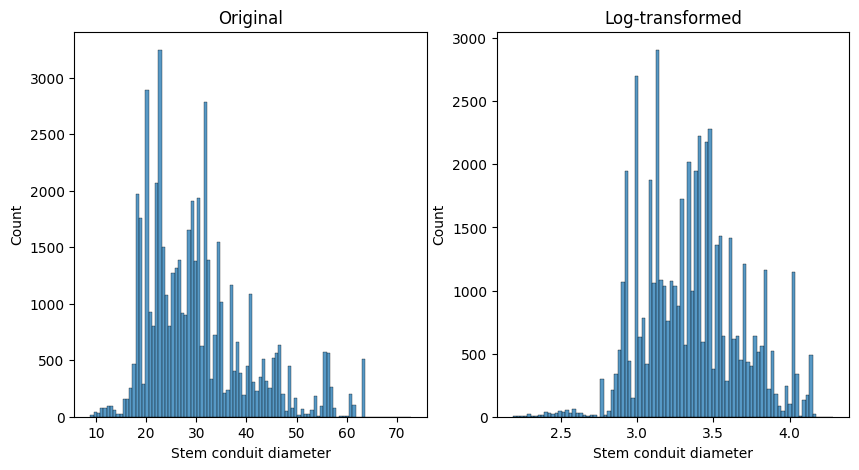

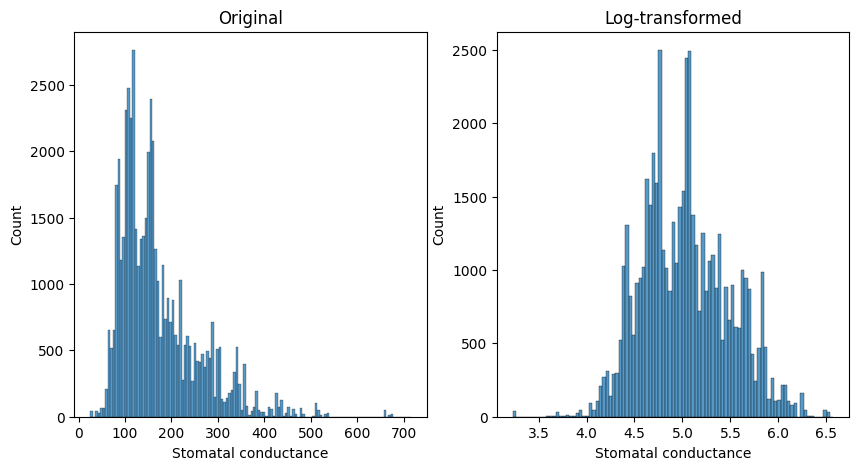

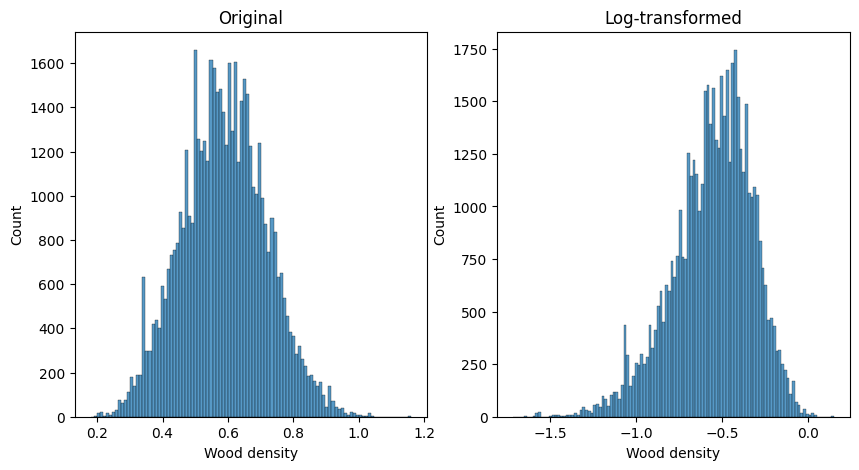

In [22]:
# plot distribution for each column in df_trait_obs
import matplotlib.pyplot as plt
import seaborn as sns

for col in df_trait_obs.columns:

    # create a figure with two columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # show original
    sns.histplot(df_trait_pred[col].dropna(), ax = axs[0])
    # show log-transform
    sns.histplot(np.log(df_trait_pred[col].dropna()), ax = axs[1])
    # title for axs
    axs[0].set_title('Original')
    axs[1].set_title('Log-transformed')
    plt.show()

In [6]:
# save the log_transformed data as a dataframe
df_trait_obs_log = np.log(df_trait_obs)

# save the log-transformed data as a csv
df_trait_obs_log.to_csv(os.path.join(data_dir, 'traits_obs_log.csv'))



In [14]:
# imput missing values
from sklearn.impute import KNNImputer

# create an imputer object
imputer = KNNImputer(n_neighbors=5)

# impute missing values
df_trait_obs_imputed = imputer.fit_transform(df_trait_obs_log)

computing for n_components =  2
computing for n_components =  5
computing for n_components =  10
computing for n_components =  20
computing for n_components =  50
computing for n_components =  100
computing for n_components =  200


C:\Users\pablo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Text(0, 0.5, 'BIC')

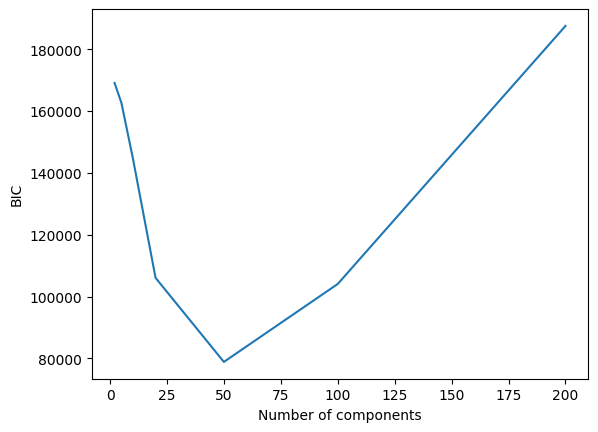

In [26]:
# fit Guassian Mixture Model
from sklearn.mixture import GaussianMixture

# we will find the best k
n_components = [2,5,10,20,50,100,200]
bic = []
for n in n_components:
    print('computing for n_components = ', n)
    gmm = GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(df_trait_obs_imputed)
    bic.append(gmm.bic(df_trait_obs_imputed))

# plot the BIC
plt.plot(n_components, bic)
plt.xlabel('Number of components')
plt.ylabel('BIC')



In [ ]:
# show describe of each trait for pred 
print('Predicted traits')
display(df_trait_pred.describe())
display(df_trait_pred.isna().sum()/len(df_trait_pred) * 100)

# show describe of each trait for obs
print('Observed traits')
display(df_trait_obs.describe())
display(df_trait_obs.isna().sum()/len(df_trait_obs) * 100)

Predicted traits


trait  Bark thickness  Crown diameter  Crown height  Leaf K per mass   
count    54153.000000    54153.000000  54153.000000     54153.000000  \
mean         4.612673       12.271934     12.185388         9.282450   
std          4.638152        7.244839      5.274005         3.919657   
min          0.346297        2.836172      3.500000         1.039242   
25%          2.218887        7.644717      7.934000         6.585408   
50%          3.418315       10.900000     11.500000         8.639048   
75%          5.076751       12.713695     15.000000        11.167049   
max         42.696171       40.000000     41.300000        27.428870   

trait  Leaf N per mass  Leaf P per mass  Leaf Vcmax per dry mass   
count     54153.000000     54153.000000             54153.000000  \
mean         19.027281         1.071144                 0.332259   
std           5.692364         0.465138                 0.120526   
min           4.614377         0.161287                 0.075431   
25%          14.461229         0.749033                 0.257505   
50%          18.281723         0.957514                 0.325743   
75%          22.495903         1.284725                 0.395261   
max          43.501226         3.895317                 0.920920   

trait      Leaf area  Leaf density  Leaf thickness    Root depth   
count   54153.000000  54153.000000    54153.000000  54153.000000  \
mean     5645.834739      0.364013        0.234297      4.130452   
std      8287.799067      0.084970        0.086764      6.279353   
min         6.636638      0.036909        0.060720      0.457200   
25%       908.874425      0.309250        0.180648      1.400000   
50%      3051.945812      0.363668        0.217734      2.700000   
75%      6524.163165      0.421389        0.265765      4.400000   
max    108949.928379      0.738055        1.210957     60.000000   

trait  Seed dry mass  Specific leaf area  Stem conduit diameter   
count   54153.000000        54153.000000           54153.000000  \
mean      494.345377           12.308504              30.049666   
std      1595.280473            4.519482              10.156595   
min         0.086550            1.453623               8.921209   
25%        12.142487            9.282996              22.502593   
50%        56.774600           11.628932              28.271873   
75%       256.670094           14.750396              34.423412   
max     41832.440705           38.463928              72.703525   

trait  Stem diameter  Stomatal conductance   Tree height  Wood density  
count   54153.000000          54153.000000  54153.000000  54153.000000  
mean        0.652116            170.892321     27.417437      0.584925  
std         0.444408             84.005882     11.290545      0.128247  
min         0.146000             25.417628      6.260000      0.179956  
25%         0.374813            111.084065     20.000000      0.497869  
50%         0.535000            152.754943     25.668357      0.580791  
75%         0.791000            205.670922     33.750000      0.671181  
max         6.480000            715.187299    119.800000      1.158583

trait
Bark thickness             0.0
Crown diameter             0.0
Crown height               0.0
Leaf K per mass            0.0
Leaf N per mass            0.0
Leaf P per mass            0.0
Leaf Vcmax per dry mass    0.0
Leaf area                  0.0
Leaf density               0.0
Leaf thickness             0.0
Root depth                 0.0
Seed dry mass              0.0
Specific leaf area         0.0
Stem conduit diameter      0.0
Stem diameter              0.0
Stomatal conductance       0.0
Tree height                0.0
Wood density               0.0
dtype: float64

Observed traits


trait  Bark thickness  Leaf K per mass  Leaf N per mass  Leaf P per mass   
count     1134.000000      1587.000000      4777.000000      3165.000000  \
mean         8.064353         9.710568        20.135614         1.233714   
std         10.820866         6.158211         7.385075         0.853508   
min          0.204571         0.250000         3.400000         0.056725   
25%          2.297900         5.516268        14.747000         0.685340   
50%          4.761102         8.120309        19.290403         1.007081   
75%          7.675052        12.301229        24.505220         1.525592   
max        137.250000        58.800000        51.780000         9.700000   

trait  Leaf Vcmax per dry mass      Leaf area  Leaf density  Leaf thickness   
count               550.000000     733.000000   1566.000000     1942.000000  \
mean                  0.363542   12704.962476      0.398406        0.240722   
std                   0.237129   25135.368273      0.136794        0.142573   
min                   0.031784       1.000000      0.020062        0.035253   
25%                   0.210255    1505.133041      0.312323        0.165281   
50%                   0.315832    4845.773480      0.392030        0.213100   
75%                   0.446798   12667.686970      0.470704        0.278720   
max                   2.207928  337534.790000      1.423935        3.030000   

trait  Seed dry mass  Specific leaf area  Stem conduit diameter   
count    5468.000000         4896.000000             259.000000  \
mean      805.846439           13.554671              29.364416   
std      4165.297071            7.069314              19.990754   
min         0.050000            0.508000               7.300000   
25%         6.490607            8.603912              15.439765   
50%        35.969104           12.422202              23.311399   
75%       224.437500           17.106214              37.083200   
max    117210.000000           76.791054             124.000000   

trait  Stomatal conductance  Wood density  
count            915.000000   7491.000000  
mean             205.854663      0.611436  
std              173.457119      0.167942  
min                5.219897      0.080000  
25%               95.000000      0.492163  
50%              149.755623      0.603676  
75%              256.209901      0.724572  
max             1192.000000      1.390000

trait
Bark thickness             90.997857
Leaf K per mass            87.401762
Leaf N per mass            62.078273
Leaf P per mass            74.874970
Leaf Vcmax per dry mass    95.633881
Leaf area                  94.181154
Leaf density               87.568469
Leaf thickness             84.583631
Seed dry mass              56.592840
Specific leaf area         61.133603
Stem conduit diameter      97.943955
Stomatal conductance       92.736366
Wood density               40.533460
dtype: float64

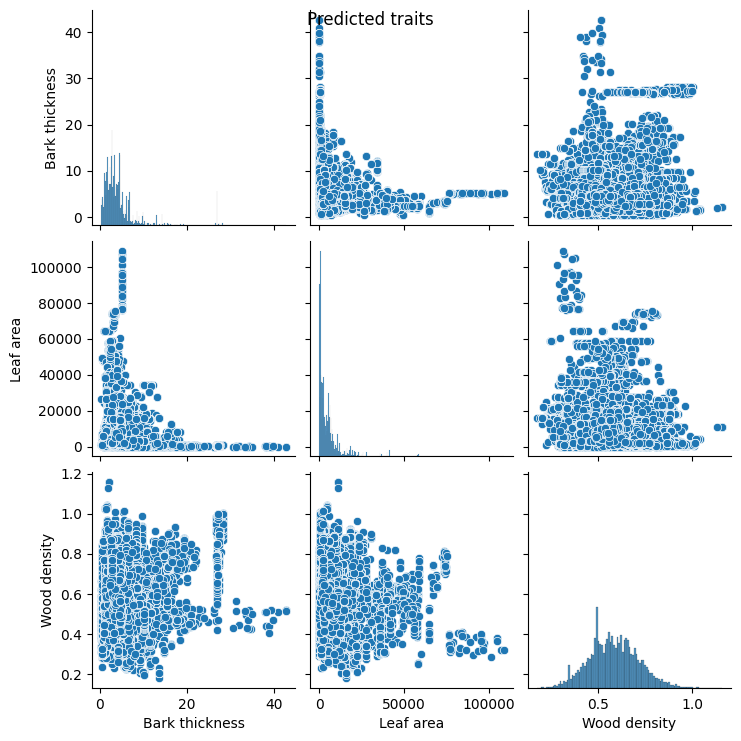

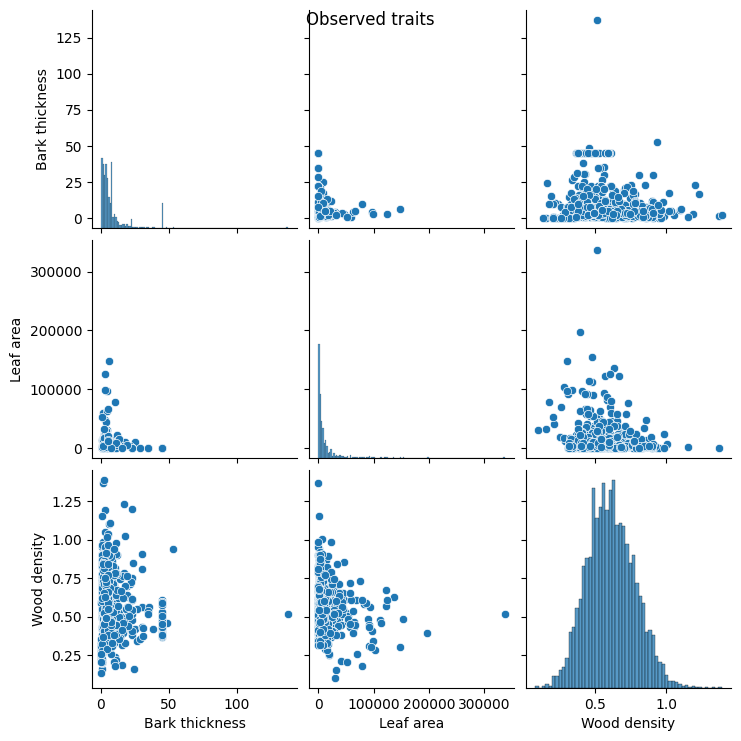

In [ ]:
# graph
import seaborn as sns
import matplotlib.pyplot as plt

some_traits = ['Bark thickness', 'Leaf area', 'Wood density']


sns.pairplot(df_trait_pred[some_traits])
plt.suptitle('Predicted traits')
plt.show()

sns.pairplot(df_trait_obs[some_traits])
plt.suptitle('Observed traits')
plt.show()